### Imports

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

#### Paths

In [7]:
RAW_DATA_PATH = '/home/jupyter/raw_data/'
DATA_PATH = '/home/jupyter/data/'

FRAME_PATH = os.path.join(os.getcwd(), 'images')  # .jpg
MASK_PATH = os.path.join(os.getcwd(), 'labels')  # .txt
METADATA_PATH = os.path.join(os.getcwd(), 'metadata') # .txt

# YOLOv3 config file directory
CONFIG_PATH = os.path.join(os.getcwd(), 'cfg')

# YOLOv3 training weights will be saved here
BACKUP_PATH = os.path.join(os.getcwd(), 'backup')

DATA_EXTENSION_FILE_PATH = os.path.join(CONFIG_PATH, 'ih_fp.data')


#### Loss

64762
1290


(800.0, 1500.0)

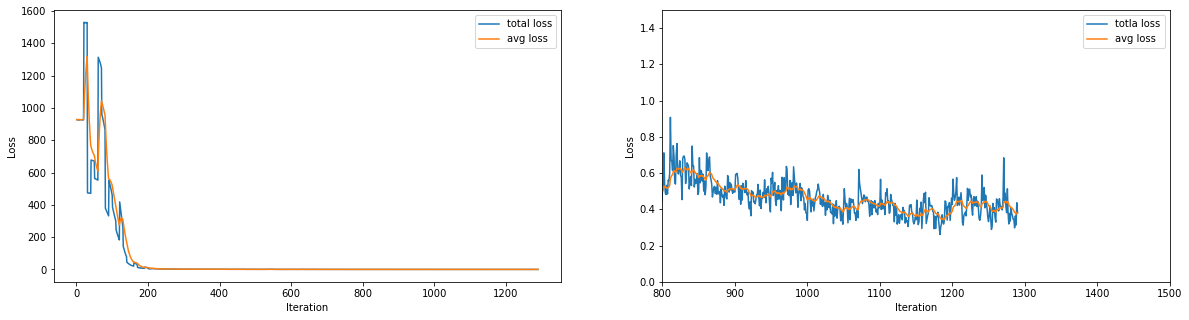

In [7]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

print(i)
print(max(iters))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 1.5])
plt.xlim([800,1500])

#### IOU

Text(0, 0.5, 'IOU')

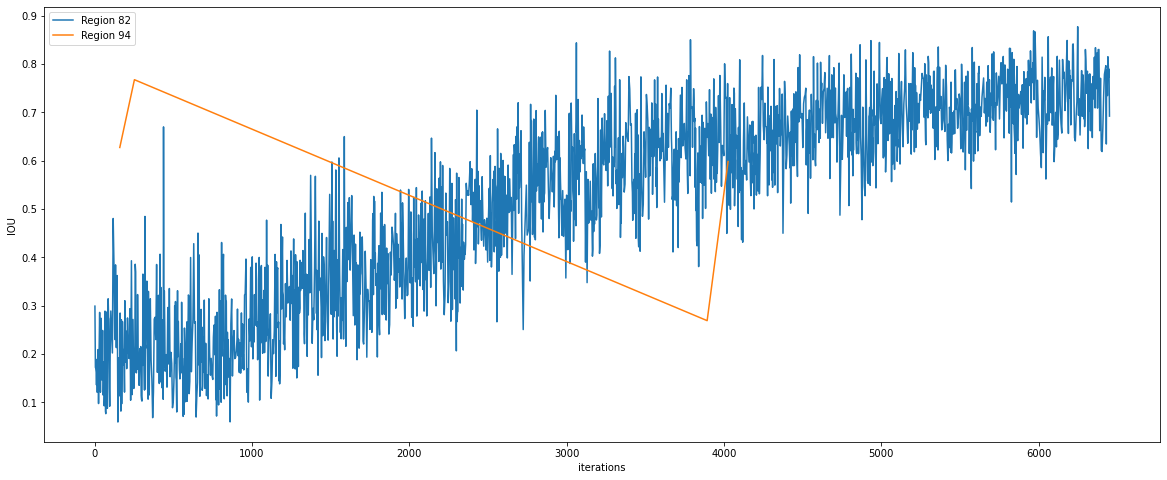

In [8]:
iters = []
IOU_value_82 = []
IOU_value_94 = []
IOU_value_106 = []

count = 0
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):

        if "Region 82" in line and count%10==0:
            
            IOU_value_82.append(float(line.strip().split(',')[0].split(' ')[4]))
            iters.append(count/10)
            
        if "Region 94" in line and count%10==0:
            
            IOU_value_94.append(float(line.strip().split(',')[0].split(' ')[4]))
     
        if "Region 106" in line and count%10==0:
            
            IOU_value_106.append(float(line.strip().split(',')[0].split(' ')[4]))
        
        count += 1
        
len_data = min(len(iters),len(IOU_value_82),len(IOU_value_94),len(IOU_value_106))
    
plt.figure(figsize=(20, 8))
sns.lineplot(iters[:len_data], IOU_value_82[:len_data], label='Region 82')
sns.lineplot(iters[:len_data], IOU_value_94[:len_data], label='Region 94')
sns.lineplot(iters[:len_data], IOU_value_106[:len_data], label='Region 106')
plt.xlabel("iterations")
plt.ylabel("IOU")

Test one image

In [9]:
#!cd darknet && ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_1200.weights ../test.jpg -thresh 0.2

Test all images

In [10]:
#yolov3-openimages.cfg      yolov3_ih_fp.cfg_test

In [15]:
!cd darknet && ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3-openimages.cfg ../backup/yolov3.weights <../metadata/test_list.txt> ../result.txt -thresh 0.1

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [8]:
!cd darknet

In [9]:
from ctypes import *

In [10]:
lib = CDLL("darknet/libdarknet.so", RTLD_GLOBAL)
darknet_lib_path = os.path.join(os.getcwd(), "darknet", "libdarknet.so")
lib = CDLL(darknet_lib_path, RTLD_GLOBAL)

In [11]:
#!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

In [22]:
from darknet import *

In [13]:
threshold = 0.1

In [14]:
submit_file_path = "submission.json"
cfg_path_2 = os.path.join(CONFIG_PATH, "yolov3_ih_fp.cfg_test")
weight_path = os.path.join(BACKUP_PATH, "yolov3_ih_fp_1200.weights")

test_img_list_path = os.path.join(METADATA_PATH, "test_list.txt")

In [15]:
#load_net = lib.load_network
#load_meta = lib.get_metadata
#load_image = lib.load_image_color

In [16]:
gpu_index = 0
net = dn.load_net(cfg_path_2.encode(),
               weight_path.encode(), 
               gpu_index)
meta = dn.load_meta(DATA_EXTENSION_FILE_PATH.encode())

In [17]:
modelConfiguration = "cfg/yolov3_ih_fp.cfg_test"
modelWeights = "backup/yolov3_ih_fp_1000.weights"

In [18]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path

In [19]:
#model = make_yolov3_model()

In [20]:
#net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
#net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

In [23]:
submit_dict = {"ImageId": [], "PredictionString": []}
count = 0
with open(test_img_list_path, "r") as test_img_list_f:
    # tqdm run up to 1000(The # of test set)
    for line in tqdm(test_img_list_f):
        #print(line.strip().encode())
        if count > 50:
            break
            
        count +=1
        image_id = line.strip().split('/')[-1].strip().split('.')[0]
        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)
        submit_line = []
        for e in infer_result:

            label = e[0]
            confi = e[1]

            rw = e[2][2]
            rh = e[2][3]
            rcx = e[2][0]
            rcy = e[2][1]
           
            
            submit_line.append([confi, rcx, rcy, rw, rh])
        submit_dict["ImageId"].append(image_id)
        submit_dict["PredictionString"].append(submit_line)


pd.DataFrame(submit_dict).to_json(submit_file_path)

51it [00:03, 13.75it/s]


In [28]:
submissions = pd.read_json('submission.json')
submissions.set_index("ImageId", inplace=True)
submissions.head(10)

,PredictionString
ImageId,
54e9212148512c08,[]
c7acfc8df59a9f47,[]
18f05c91637bb692,[]
4d60e64be911517b,[]
92e695ac674ae771,[]
5c898b1ee759a223,[]
452a31b6458bf47b,[]
928f32dd87b0b58c,[]
700bf509d6cfc13c,[]


In [6]:
ex_image_id = '54e9212148512c08'
ex_img_path = os.path.join(FRAME_PATH, "{}.jpg".format(ex_image_id))
#ex_label_path = os.path.join(MASK_PATH, "{}.txt".format(ex_image_id))
df_predict = list(submissions['PredictionString'].loc[ex_image_id])

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
plt.ylim([416, 0])
plt.xlim([0,416])

for row in df_predict:
    print(row)
    confianza, rcx, rcy, rw, rh = [float(i) for i in row]
    x = rcx - rw/2
    y = rcy - rh/2
    w = rw
    h = rh
    
    xmin = max(0,x)
    xmax = min(x+w,416)
    ymin = max(0,y)
    ymax = min(y+h,416)
    
    #plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
    plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin])
    

NameError: name 'os' is not defined

In [22]:
#!python convert.py cfg/yolov3_ih_fp.cfg backup/yolov3_ih_fp_1200.weights yolov3.h5

In [1]:
import darknet as dn
import pdb
import shutil
import numpy as np
import cv2

In [3]:
net = dn.load_net(b'./cfg/yolov3_ih_fp.cfg_test',b'./backup/yolov3_ih_fp_200.weights',0)
meta = dn.load_meta(b'./cfg/ih_fp.data')

In [5]:
print(net)

94605448600960


In [6]:
f = './images/f1a8eb8ec8d8d816.jpg'
#path = os.path.join(folder, f)
path = f
pathb = path.encode('utf-8')
print(pathb)
res = dn.detect(net, meta, pathb)
print (res)

b'./images/f1a8eb8ec8d8d816.jpg'
[]


In [35]:
predicted_image = Image.open("predictions/predicted_image0.jpg")


In [ ]:
import os
import glob
os.system
import PIL
import PIL.Image as Image

d = 0
test_Path = 'metadata/test_list.txt'
with open((test_Path),'r') as fobj:
    for line in fobj:
        image_List = [[num for num in line.split()] for line in fobj]
    for images in image_List:
        #commands = ['!cd darknet && ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_1200.weights', images[0]]
        
        #!cd darknet &&  ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_1200.weights /home/jupyter/images/c2a2d7a0d24bc7f8.jpg
        
        #os.system(' '.join(commands))
        predicted_image = Image.open("darknet/predictions.jpg")
        output = "predictions/predicted_image%d.jpg"%d
        predicted_image.save(output)
        d+=1

In [1]:
!cd darknet &&  ./darknet detector test ../cfg/ih_fp.data ../cfg/yolov3_ih_fp.cfg_test ../backup/yolov3_ih_fp_1200.weights test.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8                 104 x 